# Project

## Imports and basic setup

In [ ]:
#%matplotlib inline

In [66]:
import random
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
#from torchsummary import summary
from torch.utils.data import DataLoader, Subset, ConcatDataset, WeightedRandomSampler, SubsetRandomSampler, RandomSampler, SequentialSampler

import cv2
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [72]:
# Vanilla
# Hyperparameters
"""BATCH_SIZE = 20
SHUFFLE = True

# Data augmentations
train_transforms = transforms.Compose([
    transforms.Resize((1004, 1004)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((1004, 1004)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((1004, 1004)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
])"""

# ResNet18
# Hyperparameters
"""BATCH_SIZE = 100
SHUFFLE = True

# Data augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

# Densenet201
# ResNet101 (segmentation)
# Hyperparameters
BATCH_SIZE = 20
SHUFFLE = True
MODEL_PATH = "D:/Dev/LTU_exercises_data/m7016h/models/"

# Data augmentations
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomEqualize(1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomEqualize(1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomEqualize(1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

base_path = "D:/Dev/LTU_exercises_data/m7016h/1_covid_chest_xray/Covid19-dataset"
#base_path = "/kaggle/input/m7016h/1_covid_chest_xray/Covid19-dataset/train"

#base_path = "D:/Dev/LTU_exercises_data/project/Dataset_BUSI_with_GT"
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

print(train_path)

# Dataloaders
train_set = datasets.ImageFolder(train_path, train_transforms)
test_set = datasets.ImageFolder(test_path, train_transforms)

#val_set = datasets.ImageFolder("D:/Dev/LTU_exercises_data/project/chest_xray/val", val_transforms)
#test_set = datasets.ImageFolder("D:/Dev/LTU_exercises_data/project/chest_xray/test", test_transforms)

# Count number of instances per class and balance dataset
samples_count = torch.unique(torch.tensor(train_set.targets), return_counts=True)

for i, sample in enumerate(samples_count[0]):
    print(f'{train_set.classes[i]} ({samples_count[0][i]}) - {samples_count[1][i]}')

# Set up the weighted sampler
#weights = [1/samples_count[1][target].item() for target in train_set.targets]
#sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)


D:/Dev/LTU_exercises_data/m7016h/1_covid_chest_xray/Covid19-dataset\train
Covid (0) - 111
Normal (1) - 70
Viral Pneumonia (2) - 70


In [7]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
	def __init__(self, img_dir, mask_paths, transforms):
		# Store the image and mask filepaths, and augmentation transforms
		self.image_paths = img_dir
		self.mask_paths = mask_paths
		self.transforms = transforms
  
	def __len__(self):
		# Return the number of total samples contained in the dataset
		return len(self.image_paths)

	def __getitem__(self, idx):
		# Grab the image path from the current index
		image_path = self.image_paths[idx]
  
		# Load the image from disk, swap its channels from BGR to RGB, and read the associated mask from disk in grayscale mode
		image = cv2.imread(image_path)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.mask_paths[idx], 0)
  
		# Check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
   
		# Return a tuple of the image and its mask
		return (image, mask)


# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)

NameError: name 'trainImages' is not defined

## Models

### Functions

In [37]:
def train_model(model, criterion, optimizer, train_loader, val_loader=None, num_epochs=1):
       
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
                
        train_loss_sum = 0
        train_correct = 0
        train_total = 0
        
        model.train()
        
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)
            
            """print('')
            print(f'Predictions: {torch.argmax(predictions, 1)}')
            print('')
            print(f'Labels     : {labels}')
            print('')"""

            # Calculate loss
            loss = criterion(predictions, labels)
            train_loss_sum += loss.item() * inputs.size(0)

            # Calculate accuracy
            for i, _ in enumerate(predictions):                
                if labels[i] == torch.argmax(predictions[i]):
                    train_correct += 1
                train_total += 1
                
            # Backpropagation
            loss.backward()

            # Update parameters
            optimizer.step()
            
            # Clear
            optimizer.zero_grad()
                       
            # Print the epoch and loss
            print('\r', f'Epoch {epoch+1} Batch {batch_nr+1}/{len(train_loader)} - Train loss: {train_loss_sum / train_total:2.4f} - Accuracy: {train_correct / train_total:2.2f}', end='')
                
        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        train_losses.append(train_loss_sum / train_total)
        train_accuracies.append(train_correct / train_total)
                
        print('')
        
        if val_loader == None:
            print('No validation data, continue with training')
            continue

        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        
        model.eval()
        with torch.no_grad():
            for batch_nr, (inputs, labels) in enumerate(val_loader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                predictions = model(inputs)

                # Calculate loss
                loss = criterion(predictions, labels)
                val_loss_sum += loss.item() * inputs.size(0)

                # Calculate accuracy
                for i, _ in enumerate(predictions):
                    if labels[i] == torch.argmax(predictions[i]):
                        val_correct += 1
                    val_total += 1
                    
                # Print the epoch and loss
                print('\r', f'Epoch {epoch+1} Batch {batch_nr+1}/{len(val_loader)} - Validation loss: {val_loss_sum / val_total:2.4f} - Accuracy: {val_correct / val_total:2.2f}', end='')
                            
            # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
            val_losses.append(val_loss_sum / val_total)
            val_accuracies.append(val_correct / val_total)
                    
            print('')
    
    return model

def test_model(model, criterion, test_loader):
          
    test_losses = []
    y_pred = []
    y_true = []
        
    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    
    y_pred = torch.empty((0,), dtype=torch.int64)
    y_true = torch.empty((0,), dtype=torch.int64)
    
    model.eval()
    with torch.no_grad():

        for batch_nr, (inputs, labels) in enumerate(test_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)

            # Calculate loss
            loss = criterion(predictions, labels)
            test_loss_sum += loss.item() * inputs.size(0)

            # Calculate accuracy
            for i, _ in enumerate(predictions):
                if labels[i] == torch.argmax(predictions[i]):
                    test_correct += 1
                test_total += 1
                
            y_pred = torch.cat((y_pred, torch.argmax(predictions.cpu().detach(), 1)), 0)
            y_true = torch.cat((y_true, labels.cpu().detach()), 0)
                
            # Print the epoch and loss
            print(f'Batch {batch_nr+1}/{len(test_loader)} - Test loss: {test_loss_sum / test_total:2.4f} - Accuracy: {test_correct / test_total:2.2f}')
            print('')

        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        test_losses.append(test_loss_sum / test_total)

        # Print the epoch and loss
        print(f'Test loss: {test_loss_sum / test_total:2.4f} - Accuracy: {test_correct / test_total:2.2f}')
       
    return y_pred, y_true

### Vanilla model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 59 * 59, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Evaluate model with cross validation

# Hyperparameters
lr = 0.001
epochs = 3

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print(f'Fold no: {fold_idx + 1} -----------------------------------------------------------------')
    
    #Initialize model for each fold
    model = Net().to(device)

    # Uncomment to see model
    #summary(model, (1, 1004, 1004))

    # Define our loss function
    criterion = nn.CrossEntropyLoss()

    # Define our optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # For each fold, create a new sampler that samples from the training indices for that fold
    fold_weights = [weights[i] for i in train_idx]
    train_sampler = WeightedRandomSampler(fold_weights, len(train_idx), replacement=True)
    
    # Create data loaders for the training and validation sets using the samplers
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=train_idx)
    val_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=val_idx)

    # Train the model
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

In [7]:
# Train the model on all data (after it is balanced)
lr = 0.001
epochs = 10

#Reinitialize the model
model = Net().to(device)

# Uncomment to see model
#summary(model, (1, 1004, 1004))

# Define our loss function
criterion = nn.BCELoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)
    
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

# Save model
torch.save(trained_model.state_dict(), 'trained_model.pt')

 Epoch 1 Batch 261/261 - Train loss: 0.323260759789554 - Accuracy: 0.8666

 Epoch 1 Batch 1/1 - Validation loss: 0.5097676515579224 - Accuracy: 0.75

 Epoch 2 Batch 261/261 - Train loss: 0.12526555595122438 - Accuracy: 0.95

 Epoch 2 Batch 1/1 - Validation loss: 0.2621331214904785 - Accuracy: 0.88

 Epoch 3 Batch 261/261 - Train loss: 0.08503276266887365 - Accuracy: 0.97

 Epoch 3 Batch 1/1 - Validation loss: 0.1651245802640915 - Accuracy: 1.00

 Epoch 4 Batch 261/261 - Train loss: 0.07307932709496259 - Accuracy: 0.97

 Epoch 4 Batch 1/1 - Validation loss: 0.2989404499530792 - Accuracy: 0.94

 Epoch 5 Batch 261/261 - Train loss: 0.05424444457014209 - Accuracy: 0.988

 Epoch 5 Batch 1/1 - Validation loss: 0.28970691561698914 - Accuracy: 0.88

 Epoch 6 Batch 261/261 - Train loss: 0.05707471759557326 - Accuracy: 0.988

 Epoch 6 Batch 1/1 - Validation loss: 0.042118314653635025 - Accuracy: 1.00

 Epoch 7 Batch 261/261 - Train loss: 0.04003293961584111 - Accuracy: 0.999

 Epoch 7 Batch 1/1 

### ResNet18

In [56]:
# Evaluate model with cross validation
lr = 0.0001
epochs = 10

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print(f'Fold no: {fold_idx + 1} -----------------------------------------------------------------')
    
    """for id in val_idx:
        print(f'ID={id}: {train_set[id][1]}')"""
    
    # Initialize model for each fold
    resnet18 = models.resnet18(weights='DEFAULT')
    resnet18.fc = nn.Sequential(nn.Linear(resnet18.fc.in_features, 3))
    resnet18 = resnet18.to(device)
    
    # Count number of instances per class and balance dataset for each fold 
    train_targets = [train_set.targets[i] for i in train_idx]
    samples_count = torch.unique(torch.tensor(train_targets), return_counts=True)
    loss_weights = torch.tensor([1/samples_count[1][i].item() for i in samples_count[0]]).to(device)

    # Define our loss function
    criterion = nn.CrossEntropyLoss(weight=loss_weights)

    # Define our optimizer
    optimizer = torch.optim.Adam(resnet18.parameters(), lr)
    
    # For each fold, create a new sampler that samples from the training indices for that fold
    """fold_weights = [weights[i] for i in train_idx]
    
    train_sampler = WeightedRandomSampler(fold_weights, len(train_idx), replacement=True)
    val_sampler = SequentialSampler(val_idx)"""
    
    # Shuffle order for dataloader
    random.shuffle(train_idx)
    random.shuffle(val_idx)
    
    # Create data loaders for the training and validation sets using the samplers
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=train_idx)
    val_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=val_idx)
    
    """    print("Train")
    for data in train_loader:
        print(data[1])
    
    print("Validation")
    for data in val_loader:
        print(data[1])"""
    
    # Train the model
    train_model(resnet18, criterion, optimizer, train_loader, val_loader, epochs)

Fold no: 1 -----------------------------------------------------------------
 Epoch 1 Batch 10/10 - Train loss: 0.5501 - Accuracy: 0.81
 Epoch 1 Batch 3/3 - Validation loss: 0.6721 - Accuracy: 0.73
 Epoch 2 Batch 10/10 - Train loss: 0.0631 - Accuracy: 0.98
 Epoch 2 Batch 3/3 - Validation loss: 0.3786 - Accuracy: 0.88
 Epoch 3 Batch 10/10 - Train loss: 0.0119 - Accuracy: 1.00
 Epoch 3 Batch 3/3 - Validation loss: 0.3016 - Accuracy: 0.90
 Epoch 4 Batch 10/10 - Train loss: 0.0057 - Accuracy: 1.00
 Epoch 4 Batch 3/3 - Validation loss: 0.3161 - Accuracy: 0.88
 Epoch 5 Batch 10/10 - Train loss: 0.0037 - Accuracy: 1.00
 Epoch 5 Batch 3/3 - Validation loss: 0.2765 - Accuracy: 0.92
 Epoch 6 Batch 10/10 - Train loss: 0.0028 - Accuracy: 1.00
 Epoch 6 Batch 3/3 - Validation loss: 0.1804 - Accuracy: 0.94
 Epoch 7 Batch 10/10 - Train loss: 0.0023 - Accuracy: 1.00
 Epoch 7 Batch 3/3 - Validation loss: 0.1187 - Accuracy: 0.96
 Epoch 8 Batch 10/10 - Train loss: 0.0020 - Accuracy: 1.00
 Epoch 8 Batch 3/

In [94]:
# Train the model on all samples (after it is balanced)
lr = 0.0001
epochs = 10

resnet18 = models.resnet18(weights='DEFAULT')
resnet18.fc = nn.Sequential(nn.Linear(resnet18.fc.in_features, 3))
resnet18 = resnet18.to(device)

# Count number of instances per class and balance dataset for each fold 
samples_count = torch.unique(torch.tensor(train_set.targets), return_counts=True)
loss_weights = torch.tensor([1/samples_count[1][i].item() for i in samples_count[0]]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=loss_weights)
optimizer = torch.optim.Adam(resnet18.parameters(), lr)

# Create data loaders for training
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Train the model
trained_resnet18_model = train_model(resnet18, criterion, optimizer, train_loader, num_epochs=epochs)
torch.save(trained_resnet18_model, MODEL_PATH + 'resnet18.pth')

 Epoch 1 Batch 13/13 - Train loss: 0.4888 - Accuracy: 0.79
No validation data, continue with training
 Epoch 2 Batch 13/13 - Train loss: 0.0908 - Accuracy: 0.98
No validation data, continue with training
 Epoch 3 Batch 13/13 - Train loss: 0.0257 - Accuracy: 0.99
No validation data, continue with training
 Epoch 4 Batch 13/13 - Train loss: 0.0235 - Accuracy: 1.00
No validation data, continue with training
 Epoch 5 Batch 13/13 - Train loss: 0.0210 - Accuracy: 1.00
No validation data, continue with training
 Epoch 6 Batch 13/13 - Train loss: 0.0063 - Accuracy: 1.00
No validation data, continue with training
 Epoch 7 Batch 13/13 - Train loss: 0.0076 - Accuracy: 1.00
No validation data, continue with training
 Epoch 8 Batch 13/13 - Train loss: 0.0095 - Accuracy: 1.00
No validation data, continue with training
 Epoch 9 Batch 13/13 - Train loss: 0.0036 - Accuracy: 1.00
No validation data, continue with training
 Epoch 10 Batch 13/13 - Train loss: 0.0035 - Accuracy: 1.00
No validation data, co

### Densenet201

In [57]:
# Evaluate model with cross validation
lr = 0.0001
epochs = 10

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print(f'Fold no: {fold_idx + 1} -----------------------------------------------------------------')
    
    #Initialize model for each fold
    densenet201 = models.densenet201(weights='DEFAULT')
    densenet201.classifier  = nn.Sequential(nn.Linear(densenet201.classifier.in_features, 3))
    densenet201 = densenet201.to(device)
    
    # Count number of instances per class and balance dataset for each fold 
    train_targets = [train_set.targets[i] for i in train_idx]
    samples_count = torch.unique(torch.tensor(train_targets), return_counts=True)
    loss_weights = torch.tensor([1/samples_count[1][i].item() for i in samples_count[0]]).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=loss_weights)
    optimizer = torch.optim.Adam(densenet201.parameters(), lr)
    
    # Shuffle order for dataloader
    random.shuffle(train_idx)
    random.shuffle(val_idx)
    
    # Create data loaders for the training and validation sets using the samplers
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=train_idx)
    val_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=val_idx)

    # Train the model
    train_model(densenet201, criterion, optimizer, train_loader, val_loader, epochs)

Fold no: 1 -----------------------------------------------------------------
 Epoch 1 Batch 10/10 - Train loss: 0.6361 - Accuracy: 0.79
 Epoch 1 Batch 3/3 - Validation loss: 0.4970 - Accuracy: 0.82
 Epoch 2 Batch 10/10 - Train loss: 0.0865 - Accuracy: 1.00
 Epoch 2 Batch 3/3 - Validation loss: 0.2387 - Accuracy: 0.98
 Epoch 3 Batch 10/10 - Train loss: 0.0251 - Accuracy: 1.00
 Epoch 3 Batch 3/3 - Validation loss: 0.1428 - Accuracy: 0.98
 Epoch 4 Batch 10/10 - Train loss: 0.0121 - Accuracy: 1.00
 Epoch 4 Batch 3/3 - Validation loss: 0.1029 - Accuracy: 0.98
 Epoch 5 Batch 10/10 - Train loss: 0.0081 - Accuracy: 1.00
 Epoch 5 Batch 3/3 - Validation loss: 0.0913 - Accuracy: 0.98
 Epoch 6 Batch 10/10 - Train loss: 0.0063 - Accuracy: 1.00
 Epoch 6 Batch 3/3 - Validation loss: 0.0921 - Accuracy: 0.98
 Epoch 7 Batch 10/10 - Train loss: 0.0052 - Accuracy: 1.00
 Epoch 7 Batch 3/3 - Validation loss: 0.0977 - Accuracy: 0.98
 Epoch 8 Batch 10/10 - Train loss: 0.0045 - Accuracy: 1.00
 Epoch 8 Batch 3/

In [62]:
# Train the model on all samples (after it is balanced)
lr = 0.0001
epochs = 10

densenet201 = models.densenet201(weights='DEFAULT')
densenet201.classifier  = nn.Sequential(nn.Linear(densenet201.classifier.in_features, 3))
densenet201 = densenet201.to(device)

# Count number of instances per class and balance dataset for each fold 
samples_count = torch.unique(torch.tensor(train_set.targets), return_counts=True)
loss_weights = torch.tensor([1/samples_count[1][i].item() for i in samples_count[0]]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=loss_weights)
optimizer = torch.optim.Adam(densenet201.parameters(), lr)

# Create data loaders for training
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Train the model
trained_densenet201_model = train_model(densenet201, criterion, optimizer, train_loader, num_epochs=epochs)
torch.save(trained_densenet201_model, MODEL_PATH)

 Epoch 1 Batch 13/13 - Train loss: 0.5927 - Accuracy: 0.76
No validation data, continue with training
 Epoch 2 Batch 13/13 - Train loss: 0.0845 - Accuracy: 0.99
No validation data, continue with training
 Epoch 3 Batch 13/13 - Train loss: 0.0430 - Accuracy: 1.00
No validation data, continue with training
 Epoch 4 Batch 13/13 - Train loss: 0.0143 - Accuracy: 1.00
No validation data, continue with training
 Epoch 5 Batch 13/13 - Train loss: 0.0369 - Accuracy: 0.99
No validation data, continue with training
 Epoch 6 Batch 13/13 - Train loss: 0.0185 - Accuracy: 1.00
No validation data, continue with training
 Epoch 7 Batch 13/13 - Train loss: 0.0105 - Accuracy: 1.00
No validation data, continue with training
 Epoch 8 Batch 13/13 - Train loss: 0.0068 - Accuracy: 1.00
No validation data, continue with training
 Epoch 9 Batch 13/13 - Train loss: 0.0150 - Accuracy: 1.00
No validation data, continue with training
 Epoch 10 Batch 13/13 - Train loss: 0.0177 - Accuracy: 1.00
No validation data, co

NameError: name 'MODEL_PATH' is not defined

## Segmentation

### ResNet101

In [ ]:
resnet101 = models.segmentation.fcn_resnet101(pretrained=True).eval()

### UNet

In [ ]:
# Evaluate model with cross validation
lr = 0.0001
epochs = 5

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print(f'Fold no: {fold_idx + 1} -----------------------------------------------------------------')
    
    #Initialize model for each fold   
    unet = models.UNet().to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=loss_weights)
    optimizer = torch.optim.Adam(densenet201.parameters(), lr)

## Plots and output

In [60]:
# Test model and return prediction/target tensors
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Note: Using val data until final test when this should be changed to test
y_pred_tensor, y_true_tensor = test_model(trained_resnet18_model, criterion, test_loader)
#y_pred_tensor, y_true_tensor = test_model(trained_densenet201_model, criterion, test_loader)

Batch 1/4 - Test loss: 0.1135 - Accuracy: 0.95

Batch 2/4 - Test loss: 0.1463 - Accuracy: 0.93

Batch 3/4 - Test loss: 0.1682 - Accuracy: 0.92

Batch 4/4 - Test loss: 0.2081 - Accuracy: 0.91

Test loss: 0.2081 - Accuracy: 0.91


In [39]:
print(y_pred_tensor)
print(y_true_tensor)

tensor([1, 0, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2,
        0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 2, 1, 0, 0, 1, 2])
tensor([1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2,
        0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2])


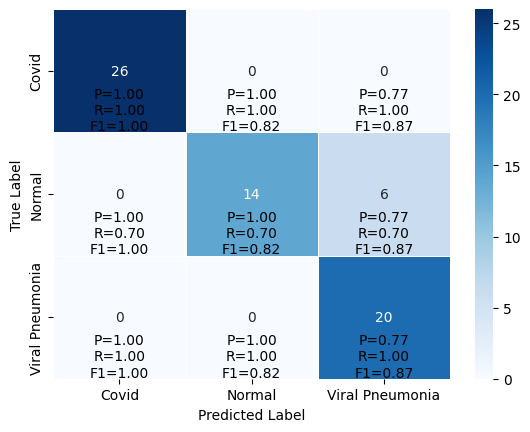

In [61]:
# Transform tensors into np arrays
y_true = y_true_tensor.numpy()
y_pred = y_pred_tensor.numpy()

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Define the label names for the plot
categories = train_set.classes
xlabel = 'Predicted Label'
ylabel = 'True Label'

# Compute precision, recall, and F1 scores
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

ax = sns.heatmap(cf_matrix, annot=True, linewidth=.5, cmap='Blues', xticklabels=categories, yticklabels=categories)

# Add the x and y axis labels
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Add precision, recall, and F1 scores as annotations to the cells
for i in range(len(categories)):
    for j in range(len(categories)):
        text = f'\nP={precision[j]:.2f}\nR={recall[i]:.2f}\nF1={f1[j]:.2f}'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='top', color='black')

### Activation Maps on First Convolutional Layer

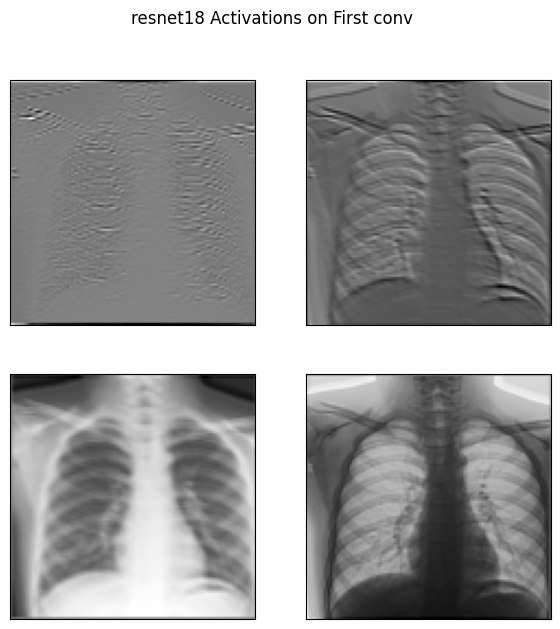

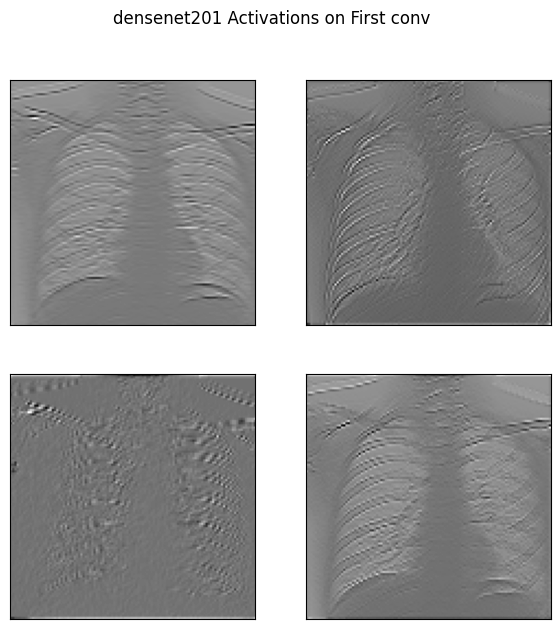

In [204]:
image = next(iter(train_loader))[0][0].to(device)

for mode in ['resnet18', 'densenet201']:
    with torch.no_grad():
        if mode == 'resnet18':
            network = trained_resnet18_model

            feature_maps = network.conv1(image)
        elif mode == 'densenet201':
            network = trained_densenet201_model
            
            feature_maps = network.features.conv0(image)

        feature_maps = feature_maps.squeeze(0)

        fig = plt.figure(figsize=(7, 7))
        fig.suptitle(mode + ' Activations on First conv')

        position = 1
        for i in range(4):
            ax = plt.subplot(2, 2, position)
            ax.set_xticks([])
            ax.set_yticks([])

            feature = feature_maps[i].cpu().numpy()
            plt.imshow(feature, cmap='gray')
            position += 1
        
        plt.show()

In [165]:
print(trained_resnet18_model)
print(trained_densenet201_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

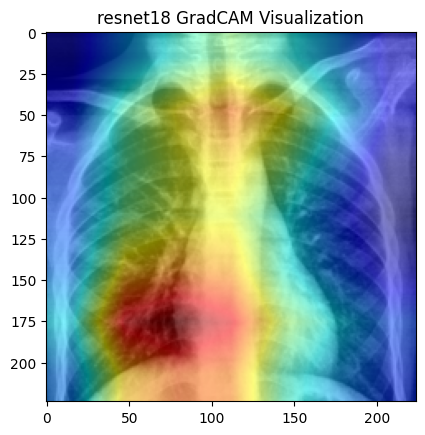

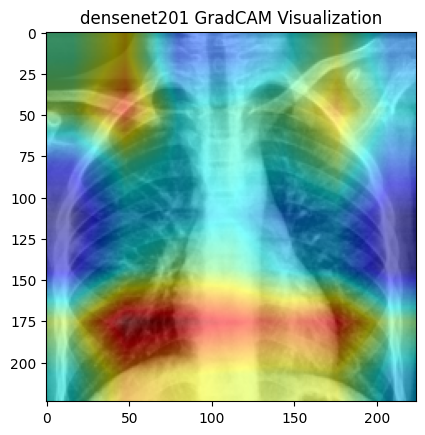

In [209]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

batch_tensor = next(iter(train_loader))[0].to(device)

for mode in ['resnet18', 'densenet201']:
    if mode == 'resnet18':
        network = trained_resnet18_model

        target_layers = [network.layer4[-1]]

    elif mode == 'densenet201':
        network = trained_densenet201_model

        target_layers = [network.features[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=network, target_layers=target_layers, use_cuda=1)
    
    grayscale_cam = cam(input_tensor=batch_tensor[0].unsqueeze(0), targets=None)
    grayscale_cam = grayscale_cam[0, :]
    
    # Normalize to [0, 1]
    batch_tensor -= batch_tensor.min(3, keepdim=True)[0]
    batch_tensor /= batch_tensor.max(3, keepdim=True)[0]
    
    batch_tensor = batch_tensor.cpu()
    
    visualizations= show_cam_on_image(batch_tensor[0].numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
    
    plt.imshow(visualizations)
    plt.title(mode + ' GradCAM Visualization')
    plt.show()

In [205]:
from sklearn.manifold import TSNE

def visualize_tsne(features, labels, net_name):
        tsne_transformed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(features)
        
        fig, ax = plt.subplots()
        scatter = ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels)
        
        fig.colorbar(scatter)

        plt.xlabel('t-SNE dimension 1')
        plt.ylabel('t-SNE dimension 2')
        plt.title(net_name + ' t-SNE plot')

        plt.show()

(20, 3)


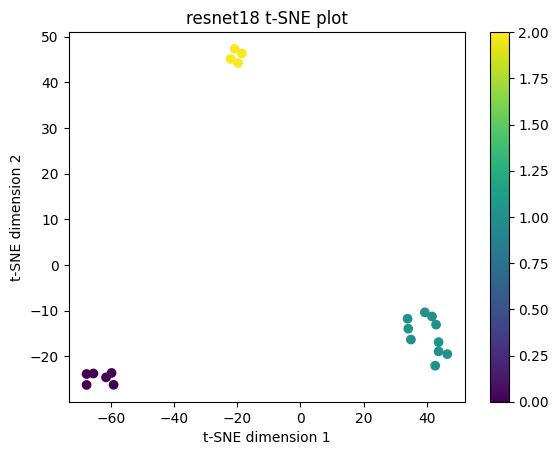

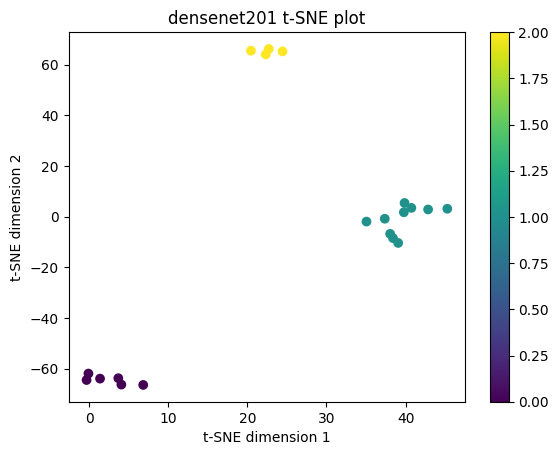

In [207]:
batch = next(iter(train_loader))
images, labels = batch[0].to(device), batch[1]

for mode in ['resnet18', 'densenet201']:
    with torch.no_grad():
        if mode == 'resnet18':
            network = trained_resnet18_model

            features = network(images).view(BATCH_SIZE, -1).cpu().numpy() 
            print(features.shape)

        elif mode == 'densenet201':
            network = trained_densenet201_model

            features = network(images).view(BATCH_SIZE, -1).cpu().numpy() 

        visualize_tsne(features, labels, mode)